# 2 - Deep Dive into Random Forrests
[Course Notebook on Github](https://github.com/fastai/fastai/blob/master/courses/ml1/lesson1-rf.ipynb)
### Notes
My goal is not to copy what it is taught in the course and in the notebook. Its just various notes and trying things for my own.

In [12]:
# import
%load_ext autoreload
%autoreload 2


%matplotlib inline
# libs
import os
import pandas as pd
import numpy as np
import re, time
from sklearn.ensemble import RandomForestRegressor

from fastai.imports import *
from fastai.structured import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Redifine r^2

Creating the Validation set - IMPORTANT! Come up with a dataset that is a representative.

Validation set with the same properties.

In [13]:
PATH = './datasets/bluebook_bulldozers/'
df_raw = pd.read_csv(f'{PATH}Train.csv', low_memory=False, parse_dates=['saledate'])#implicity datetype)

In [14]:
def display_all(df):
    with pd.option_context('display.max_rows', 1000):
        with pd.option_context('display.max_columns', 1000):
            display(df)

In [15]:
display_all(df_raw.tail().transpose())

,401120,401121,401122,401123,401124
SalesID,6333336,6333337,6333338,6333341,6333342
SalePrice,10500,11000,11500,9000,7750
MachineID,1840702,1830472,1887659,1903570,1926965
ModelID,21439,21439,21439,21435,21435
datasource,149,149,149,149,149
auctioneerID,1,1,1,2,2
YearMade,2005,2005,2005,2005,2005
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
saledate,2011-11-02 00:00:00,2011-11-02 00:00:00,2011-11-02 00:00:00,2011-10-25 00:00:00,2011-10-25 00:00:00


In [16]:
df_raw.SalePrice = np.log(df_raw.SalePrice)

In [18]:
m = RandomForestRegressor(n_jobs=-1)
# The following code is supposed to fail due to string values in the input data
m.fit(df_raw.drop('SalePrice', axis=1), df_raw.SalePrice)

ValueError: could not convert string to float: 'Conventional'

In [19]:
add_datepart(df_raw, 'saledate')
df_raw.saleYear.head()

0    2006
1    2004
2    2004
3    2011
4    2009
Name: saleYear, dtype: int64

In [20]:
train_cats(df_raw)


In [21]:
df_raw.UsageBand.cat.set_categories(['High', 'Medium', 'Low'], ordered=True, inplace=True)


In [22]:
df_raw.UsageBand = df_raw.UsageBand.cat.codes


In [23]:
display_all(df_raw.isnull().sum().sort_index()/len(df_raw))


Backhoe_Mounting            0.803872
Blade_Extension             0.937129
Blade_Type                  0.800977
Blade_Width                 0.937129
Coupler                     0.466620
Coupler_System              0.891660
Differential_Type           0.826959
Drive_System                0.739829
Enclosure                   0.000810
Enclosure_Type              0.937129
Engine_Horsepower           0.937129
Forks                       0.521154
Grouser_Tracks              0.891899
Grouser_Type                0.752813
Hydraulics                  0.200823
Hydraulics_Flow             0.891899
MachineHoursCurrentMeter    0.644089
MachineID                   0.000000
ModelID                     0.000000
Pad_Type                    0.802720
Pattern_Changer             0.752651
ProductGroup                0.000000
ProductGroupDesc            0.000000
ProductSize                 0.525460
Pushblock                   0.937129
Ride_Control                0.629527
Ripper                      0.740388
S

In [24]:
os.makedirs('tmp', exist_ok=True)
df_raw.to_feather('tmp/bulldozers-raw')

In [25]:
df, y, nas = proc_df(df_raw, 'SalePrice')

In [27]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(df, y)
m.score(df,y)

0.9829834790091507

In [30]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

n_valid = 12000  # same as Kaggle's test set size
n_trn = len(df)-n_valid
raw_train, raw_valid = split_vals(df_raw, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((389125, 66), (389125,), (12000, 66))

In [28]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [31]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 1min 18s, sys: 403 ms, total: 1min 19s
Wall time: 9.61 s
[0.09054585733191532, 0.25047483329166936, 0.9828654778810968, 0.887959208951931]


Big so I can remember.
# RULE OF THUMB: IF SOMETHING TAKES MORE THAN 10s TO RUN ITS TO LONG ITS TOO LONG TO MAKE INTERACTIVE ANALYSIS!

In [33]:
# speeding things up
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice', subset=30000, na_dict=nas)
X_train, _ = split_vals(df_trn, 20000)
y_train, _ = split_vals(y_trn, 20000)

In [34]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 2.78 s, sys: 15.1 ms, total: 2.79 s
Wall time: 460 ms
[0.11095700178641811, 0.3642689581941429, 0.9728027116831143, 0.7630305823227951]


### Single Tree

In [35]:
m = RandomForestRegressor(n_estimators=1, max_depth=3, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.5217509592951793, 0.5828443596295697, 0.39862870850528476, 0.3933290912578165]


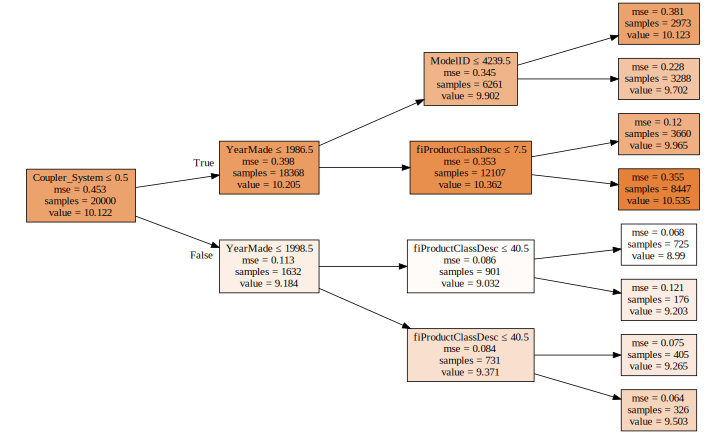

In [36]:
draw_tree(m.estimators_[0], df_trn, precision=3)

In [37]:
m = RandomForestRegressor(n_estimators=1, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[3.1568979266172195e-06, 0.5564595897148331, 0.9999999999779842, 0.4470125993409144]


#### Bagging

In [38]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.1127948319079367, 0.38005986191024693, 0.9718942886283114, 0.7420402268002548]


In [39]:
preds = np.stack([t.predict(X_valid) for t in m.estimators_])
preds[:,0], np.mean(preds[:,0]), y_valid[0]

(array([ 9.21034,  9.30565,  8.9872 ,  9.25913,  8.92266,  9.3501 ,  8.92266,  9.68034,  9.51044, 10.37349]),
 9.352201734139474,
 9.104979856318357)

In [40]:
preds.shape

(10, 12000)

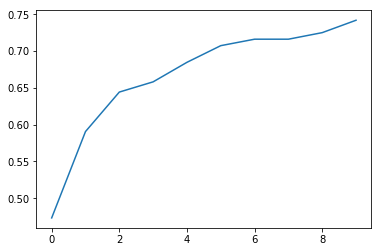

In [47]:
plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(10)]);


In [42]:
m = RandomForestRegressor(n_estimators=20, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.10119066140179807, 0.35937767310799396, 0.9773797683387108, 0.7693517526812312]


In [44]:

m = RandomForestRegressor(n_estimators=40, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.09779873806421142, 0.3608572427992955, 0.9788708181380371, 0.7674486703736052]


In [46]:
m = RandomForestRegressor(n_estimators=80, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)


[0.09428714509698852, 0.35802399130260426, 0.9803609194550559, 0.771086063549204]


### Out-of-bag Score

In [48]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.09672884667476582, 0.35258351295357726, 0.9793305843650338, 0.7779902871777421, 0.8522492081563198]


In [49]:
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)

In [50]:
len(X_train)

389125

In [51]:
set_rf_samples(20000)

In [52]:
m = RandomForestRegressor(n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 7.72 s, sys: 392 ms, total: 8.11 s
Wall time: 2.7 s
[0.24068694399559792, 0.2784892310469463, 0.8789290663523266, 0.8614952122708625, 0.8664152898609715]


In [53]:

m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.22708727766644124, 0.26267447394592447, 0.8922244037784479, 0.8767792873156015, 0.8807204088109685]


In [54]:
??set_rf_samples

Signature: set_rf_samples(n)
Source:   
def set_rf_samples(n):
    """ Changes Scikit learn's random forests to give each tree a random sample of
    n random rows.
    """
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n))
File:      ~/Code/projects/dsml-learning/Intro_ML_Coders/fastai/structured.py
Type:      function


**NOTE**: Do most of interactive modelling on a reasonable amount of data (so that the accuracy doesn't fall to much), but it takes less time to train, so the insights are gained faster.

In [56]:
reset_rf_samples()

In [57]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.07833262789621162, 0.23778518762605644, 0.9871760971578643, 0.899024138034615, 0.9086137079772423]


In [58]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.11510079083649992, 0.23350791041375946, 0.9723120092444736, 0.9026241707849366, 0.9084327698247908]


min_samples_leaf = [1, 3, 5, 25]

In [59]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.11913507940985597, 0.22778615303654057, 0.9703370634112556, 0.9073377984898046, 0.9117434940985439]
